In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# This notebook shows potential shape extraction and manipulation code

potentially the algorithm can make use of it ???

In [2]:
# helper function that inputs a string of the name of the ore and gets the texture
def get_ore(ore):
    ore = ore.replace(" ","_")
    if not "ore" in ore:
        ore += "_ore"
    return mpimg.imread('textures/valuableBlocks/{}.png'.format(ore))

img = get_ore("diamond")

img = mpimg.imread('data/image_0.png')


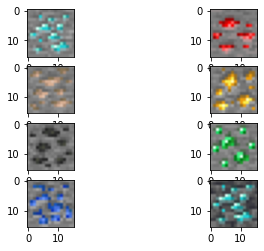

In [3]:
ores = ['diamond','redstone','iron','gold','coal','emerald','lapis','deepslate diamond']
ore_images = {ore:get_ore(ore) for ore in ores}
nrows = int((len(ores)/2))
fig, ax = plt.subplots(nrows,2)
i, j = 0,0
for ore, axis in zip(ore_images.values(),ax.flatten()):
    axis.imshow(ore)

plt.show()

In [4]:
def stone(color,sensitivity):
        '''
        currently a dumb model to calculate if the color is grey
        '''
        r,g,b, = 255*color[:3]
        if (abs(g-r) > sensitivity or
            abs(g-b) > sensitivity or
            abs(r-b) > sensitivity ):
            return False
        else:
            return True
        
def getshape(imageMat, return_colors = False, f = None, sensitivity = None):
    '''
    inputs an image and extracts the pixels that aren't grey
    returns: array of x values and array of y values for the pixels, (and the color of those pixels)
    
    '''
    if f == None:
        f = lambda x: stone(color, 0 if sensitivity == None else sensitivity)
    x_points, y_points = [],[]
    if(return_colors):
        colors = []
    for y, xmatr in enumerate(imageMat):
        for x, color in enumerate(xmatr):
            if not f(color):
                x_points.append(x)
                y_points.append(y)
                if(return_colors):
                    colors.append(color)
    if return_colors:
        return x_points, y_points, colors 
    else:
        return x_points, y_points

Essentially the function above scans an image and returns the x and the y coords of any point that isn't grey (but we could just as easily play around with the filter)

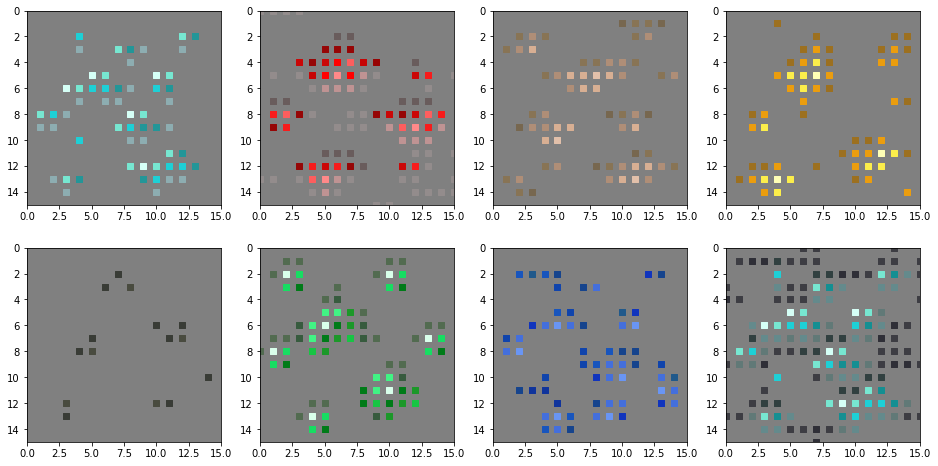

In [5]:
fig, ax = plt.subplots(2,int(len(ore_images)/2),figsize=(16,8))

for ore, axis in zip(ore_images.values(),ax.flatten()):
    x, y, colors = getshape(ore,return_colors=True)
    axis.set_facecolor('grey')
    axis.invert_yaxis()
    axis.scatter(x,y, marker='s', color=colors)
    axis.set_aspect('equal')
    axis.set_xbound(0,15),axis.set_ybound(0,15)

Now that I have coordinates I can do a bit of numerical computations stuff to manipulate it

In [6]:
def reflect(theta,x,y):
    v = np.array([np.cos(theta),np.sin(theta)])
    v = np.reshape(v,(2,1))
    
    X = np.array([x, y])
    I = np.identity(2)
    
    reflect_array = I - 2*np.matmul(v,v.T)
    
    reflectedX = np.matmul(reflect_array,X)
    
    return reflectedX[0], reflectedX[1]

def rotate(theta,x,y):
    '''
    inputs a theta, an x and a y and rotates x and y using 
    the associated rotation matrix    
    '''
    X = np.array([x,y]) 
    sin = np.sin(theta)
    cos = np.cos(theta)
    A = np.array([
        [cos, -sin],
        [sin, cos]
    ])
    Xr = np.dot(A,X)
    return Xr[0], Xr[1]

def rotate_around_pivot(theta,x,y,pivot=None):
    '''
    rotates the shape theta degrees around pivot point
    if no pivot point is selected, defaults to the center
    pivot is inputted as a tuple , e.g (1,1)
    '''
    if pivot == None:
        pivotx = (max(x)-min(x))/2
        pivoty = (max(y)-min(y))/2
    else:
        pivotx, pivoty = pivot
    x_ = list(map(lambda x: x - pivotx, x))
    y_ = list(map(lambda y: y - pivoty, y))
    xr, yr = rotate(theta,x_,y_)
    xr = list(map(lambda x: x + pivotx, xr))
    yr = list(map(lambda y: y + pivoty, yr))
    return xr, yr
    
    

One potential use case is to allow the algorithm to have a broader scope in matching shapes. For example, in figure 3 the blue shape is just the emeralds in data0.png rotated $45^o$ and thus if the KNN was matching with multiple rotations it would be able to identify it.

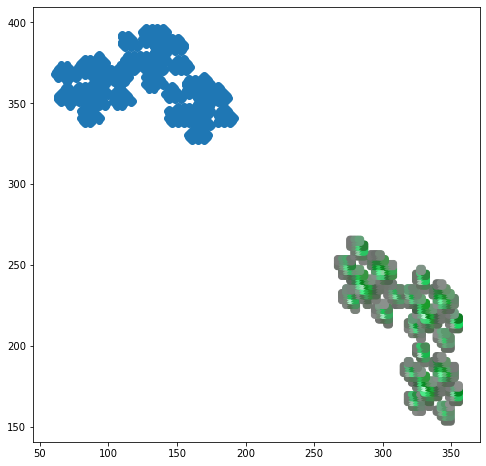

In [7]:
x,y, color = getshape(img, return_colors = True)

xr,yr = rotate_around_pivot(np.pi/4, x,y)
fig, ax = plt.subplots(figsize=(8,8))

plt.scatter(xr,yr)
plt.scatter(x,y, color = color)

plt.show()

Here is also a test on the reflection code

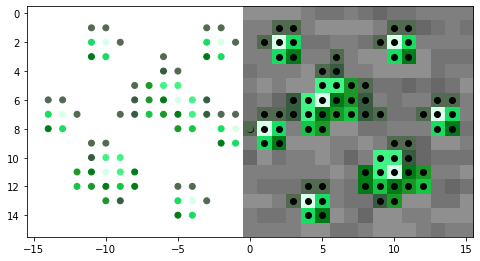

In [8]:
x,y, color = getshape(ore_images["emerald"],return_colors = True)
xr, yr = reflect(np.pi,x,y)
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(ore_images['emerald'])
ax.scatter(x,y,color="black")
ax.scatter(xr,yr,color=color)


---
# But wait there is more ...

Initially the only purpose of the `get_shape()` function was to have points to manipulate using some numerical computations stuff but theoretically we could use it for a predict based on shape method

In [9]:
# proof of concept 
def get_centered_shape(image):
    '''
    call get_shape and manipulate the return value of get shape so that the center of the shape is at (0,0)
    '''
    x,y, color = getshape(image, return_colors = True)
    
    X = np.array([x,y])
    
    for i in range(2):
        center = np.average(X[i])
        X[i] -=  int(center)
    
    return X[0], X[1], color
    
    

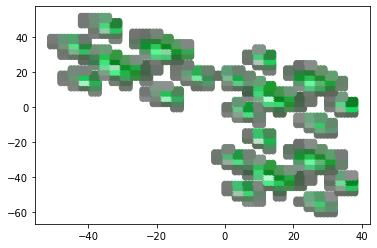

In [10]:
x,y, color = get_centered_shape(img)

fig, ax = plt.subplots()
ax.scatter(x,y, color = color)

plt.show()

Psudocode of this idea for the predict method
```
predict( input image ):
    # get the (x,y) coordinates of the pixels of interest
    x, y = get_shape( input image )
    
    # center the shape onto some universal reference point
    x_centered, y_centered = center(x, y)
    
    prediction from shape = KNN(x_centered, y_centered)
    
    if( can't predict from shape ):
        # try some rotations or something 
    else:
        get location info from x and y
        return prediction_from_shape and location info 
    
```

# Note: 
All of this is just a proof of concept using just `numpy` and `matplotlib` stuff, if we decide to use this idea we can work on making these functions more efficient.

### An animation of all of the ores rotating the full 360 degrees

I put it at the end of the notebook so that it wouldn't ruin the other plots
run if you want

In [ ]:
%matplotlib notebook
%matplotlib notebook
import matplotlib.animation
from matplotlib.animation import FuncAnimation 
x, y, colors = get_centered_shape(ore_images["diamond"])
fig, ax = plt.subplots(figsize=(8,8))
points, = ax.plot(x, y,'o-',color="black",linewidth=0)
ax.set_xbound(-16,16)
ax.set_ybound(-16,16)

    
def animate(i):
    
    degrees = (i)%361
    curr_ore = ores[int((i-degrees)/360)]
    ax.set_title("{}: angle = {}°".format(curr_ore,degrees))
    x, y, colors = get_centered_shape(ore_images[curr_ore])
    color = np.average(colors,axis=0)
    xr, yr = rotate(degrees*(np.pi/180), x,y)
    points.set_color(color)
    points.set_data(xr,yr)
    return points,

anim = FuncAnimation(fig, animate, frames=361*len(ores), interval = 20, repeat=False)
plt.show()
